In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v3
from draw import draw  #绘图函数
from ExperienceReplayBuffer import ExperienceReplayBuffer
import tqdm

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v3.GridWorld_v3(forbiddenAreaScore=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()
trajectorySteps = 1000

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [3]:
state_values = np.array([random.random() for i in range(25)])
learning_rate = 0.01
gamma = 0.99

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,5)  #拟合的Action value，5个方向的 q值
    def forward(self, state):
        h1 = self.fc1(state)
        h1 = F.relu(h1)
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        Q = self.fc3(h2)
        return Q
        

In [5]:
experiencePool = ExperienceReplayBuffer(max_size=10000)
policy = 0.2 * np.ones((rows*columns,5))
episodes = [gridworld.getTrajectoryScore(nowState = 10,action = random.randint(0,4),policy = policy) 
            for i in range(500)]
for trajectory in episodes:
    for exp in trajectory:
        experiencePool.add_expericence(exp)

In [6]:
lr = 0.0015
network = model()
optimizer = optim.Adam(network.parameters(), lr = lr)
batch_size = 100

In [7]:
batch_size = 10
batch = experiencePool.sample_batch(batch_size=batch_size)
tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

tmpstate = tmpstate.reshape(batch_size,1)
tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  #将state变成了行列
nextState = nextState.reshape(batch_size,1)
nextState = np.hstack((nextState // 5, nextState % 5))  #将state变成了行列

tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

# tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
# nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

In [11]:
nextAction.shape

(10,)

# 简单的正向计算

In [16]:
# 以下一个state出发，计算下一个state的五个action values
next_action_values = network(nextState)  #网络
print(next_action_values.shape)



b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1) #next_action_value

# c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
# next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)

target = tmpscore + (1.0 - terminal) * gamma * next_action_value  #得到当前的target值，action value的值

torch.Size([10, 5])


In [12]:
nextAction[0]

2

In [15]:
next_action_values[0,2] 

tensor(0.5080, grad_fn=<SelectBackward0>)

In [9]:
next_action_values

tensor([[-0.0674, -0.0987,  0.5080,  0.4438, -0.0261],
        [-0.1975, -0.2176,  0.5678,  0.5899, -0.1355],
        [-0.2138, -0.1101,  0.9722,  0.8650,  0.1423],
        [-0.0674, -0.0987,  0.5080,  0.4438, -0.0261],
        [-0.1538, -0.1870,  0.3959,  0.4357, -0.0996],
        [-0.0431, -0.0963,  0.7350,  0.4856, -0.0548],
        [-0.1975, -0.2176,  0.5678,  0.5899, -0.1355],
        [-0.0813, -0.1539,  0.2273,  0.3027, -0.0765],
        [-0.1326, -0.0846,  0.7937,  0.6500,  0.0240],
        [-0.2351, -0.1833,  0.8299,  0.7938,  0.0839]],
       grad_fn=<AddmmBackward0>)

In [10]:
b

[tensor(-0.0569, grad_fn=<SelectBackward0>),
 tensor(-0.0640, grad_fn=<SelectBackward0>),
 tensor(-0.0617, grad_fn=<SelectBackward0>),
 tensor(-0.0039, grad_fn=<SelectBackward0>),
 tensor(-0.0662, grad_fn=<SelectBackward0>),
 tensor(0.1835, grad_fn=<SelectBackward0>),
 tensor(-0.1111, grad_fn=<SelectBackward0>),
 tensor(-0.0546, grad_fn=<SelectBackward0>),
 tensor(-0.0114, grad_fn=<SelectBackward0>),
 tensor(-0.0528, grad_fn=<SelectBackward0>)]

In [11]:
next_action_value

tensor([[-0.0569],
        [-0.0640],
        [-0.0617],
        [-0.0039],
        [-0.0662],
        [ 0.1835],
        [-0.1111],
        [-0.0546],
        [-0.0114],
        [-0.0528]])

In [17]:
# 通过神经网络计算当前状态对应的动作价值
now_action_values = network(tmpstate)    #网络，（bs,5）

# 提取批次中第一个样本的动作价值
now_action_value = now_action_values[0,tmpaction[0]]

# 遍历批次中剩余的样本，将每个样本对应的动作价值拼接起来
for i in range(1,batch_size):
    # 将当前的动作价值和新样本的动作价值在第0维上拼接
    now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)

# 调整动作价值张量的形状，使其成为一个二维张量，每行一个动作价值
now_action_value = now_action_value.view(-1,1)

In [18]:
now_action_value.shape

torch.Size([10, 1])

In [13]:
tmpaction

array([1, 3, 4, 2, 4, 2, 3, 3, 1, 4])

In [14]:
now_action_values

tensor([[-0.0461, -0.0678, -0.0987,  0.1776, -0.0386],
        [-0.0879, -0.0303, -0.0437,  0.1865, -0.0626],
        [-0.0617,  0.0195, -0.0528,  0.2326, -0.1171],
        [-0.1181, -0.0514, -0.1513,  0.0893, -0.0614],
        [-0.0662,  0.1000, -0.1713,  0.1272, -0.0209],
        [-0.0879, -0.0303, -0.0437,  0.1865, -0.0626],
        [-0.1135,  0.0103, -0.0172,  0.2129, -0.0634],
        [-0.0546,  0.0501, -0.2165,  0.1173, -0.0312],
        [-0.0662,  0.1000, -0.1713,  0.1272, -0.0209],
        [-0.0617,  0.0195, -0.0528,  0.2326, -0.1171]],
       grad_fn=<AddmmBackward0>)

In [15]:
now_action_value

tensor([[-0.0678],
        [ 0.1865],
        [-0.1171],
        [-0.1513],
        [-0.0209],
        [-0.0437],
        [ 0.2129],
        [ 0.1173],
        [ 0.1000],
        [-0.1171]], grad_fn=<ViewBackward0>)

# Sarsa的神经网络解决，与DQN

  0%|          | 0/5000 [00:00<?, ?it/s]

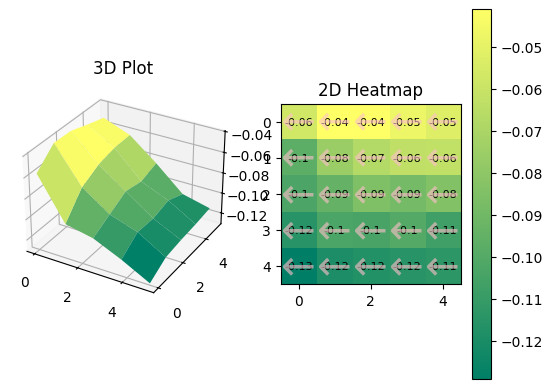

  2%|▏         | 88/5000 [00:00<00:10, 470.88it/s]

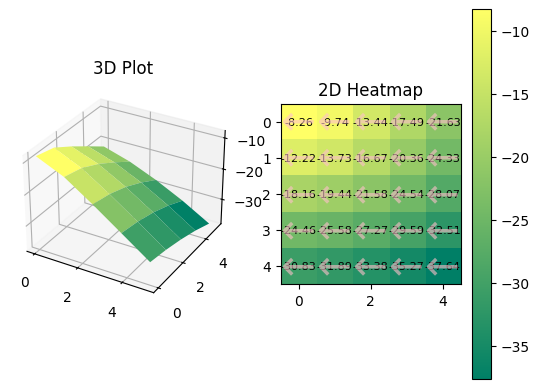

  3%|▎         | 140/5000 [00:00<00:12, 394.28it/s]

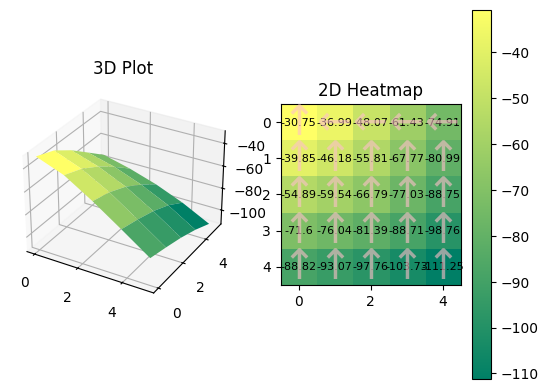

  6%|▌         | 293/5000 [00:00<00:09, 519.18it/s]

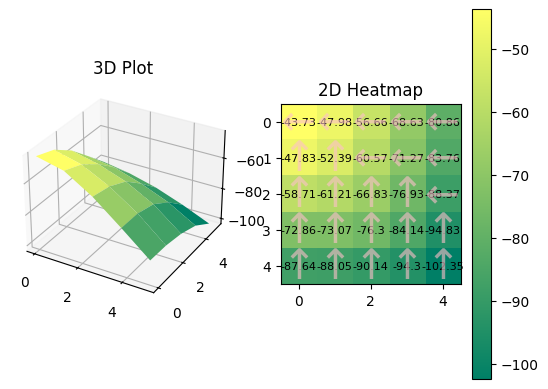

  7%|▋         | 352/5000 [00:00<00:10, 452.14it/s]

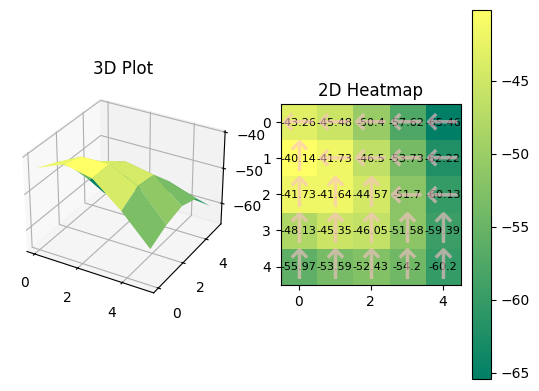

 10%|▉         | 494/5000 [00:01<00:08, 529.13it/s]

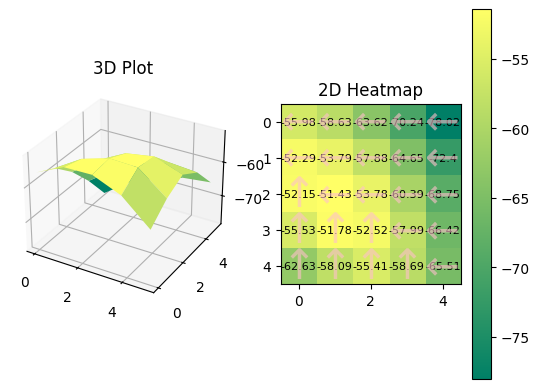

 11%|█         | 554/5000 [00:01<00:10, 416.55it/s]

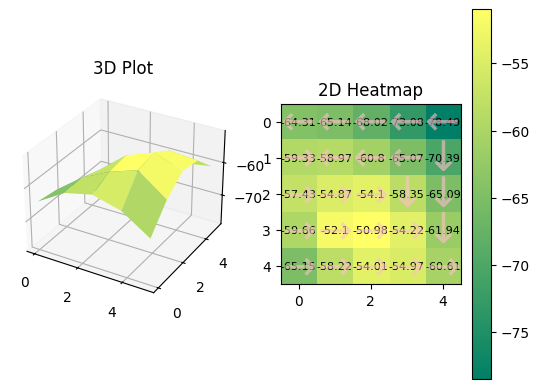

 14%|█▍        | 700/5000 [00:01<00:08, 515.35it/s]

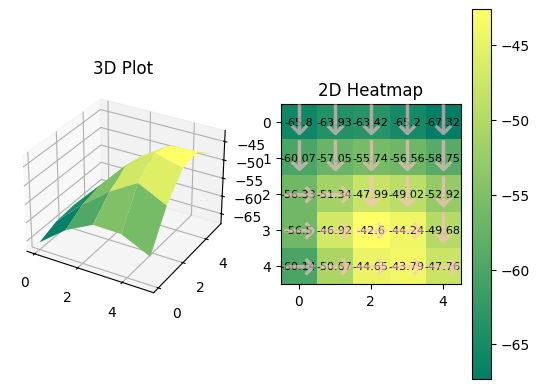

 15%|█▌        | 760/5000 [00:01<00:09, 456.44it/s]

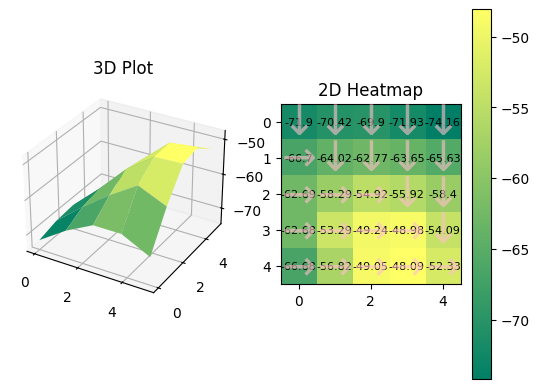

 16%|█▋        | 813/5000 [00:01<00:10, 418.43it/s]

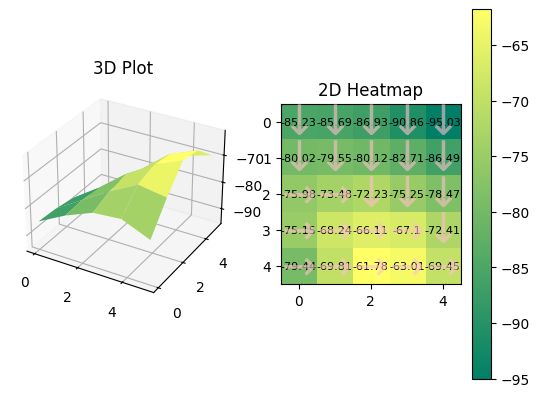

 20%|█▉        | 986/5000 [00:02<00:07, 507.95it/s]

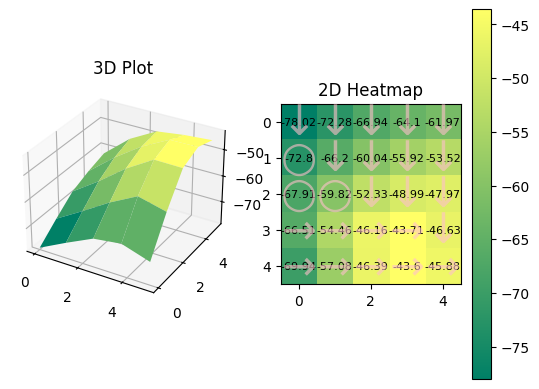

 21%|██        | 1044/5000 [00:02<00:08, 453.64it/s]

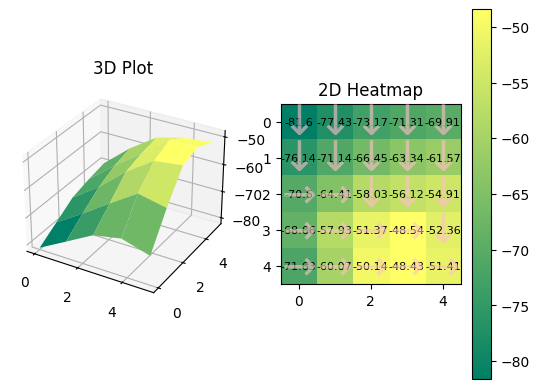

 24%|██▍       | 1189/5000 [00:02<00:07, 516.07it/s]

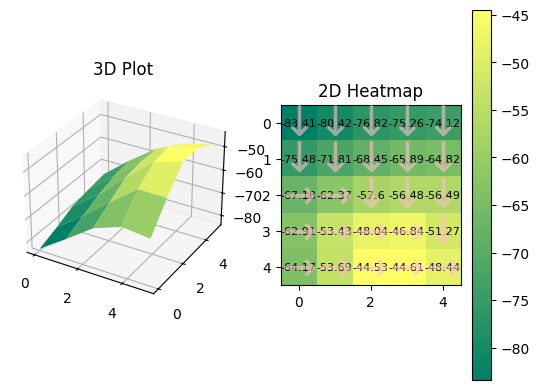

 25%|██▍       | 1248/5000 [00:02<00:09, 404.36it/s]

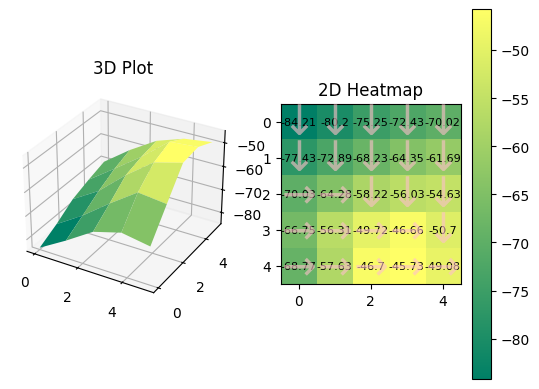

 28%|██▊       | 1391/5000 [00:03<00:07, 482.99it/s]

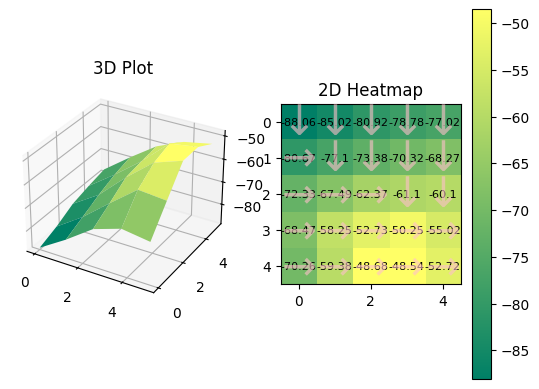

 29%|██▉       | 1448/5000 [00:03<00:08, 433.83it/s]

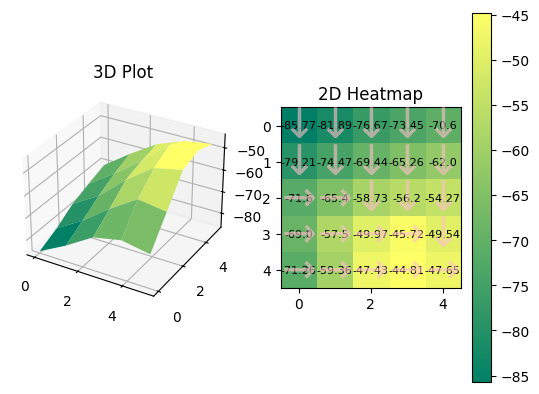

 32%|███▏      | 1592/5000 [00:03<00:06, 506.46it/s]

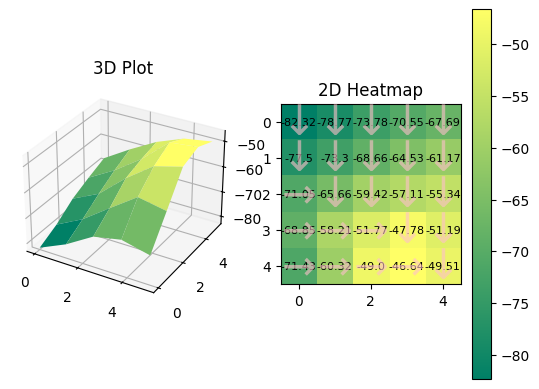

 33%|███▎      | 1651/5000 [00:03<00:07, 447.31it/s]

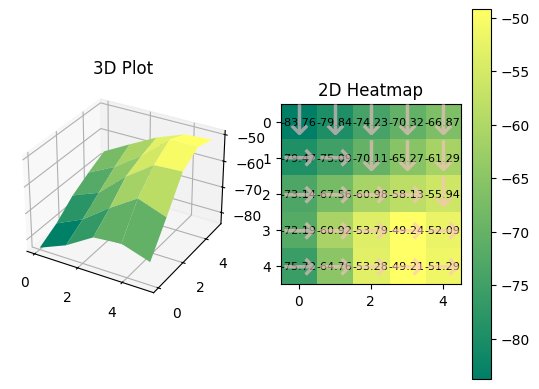

 36%|███▌      | 1789/5000 [00:04<00:06, 506.89it/s]

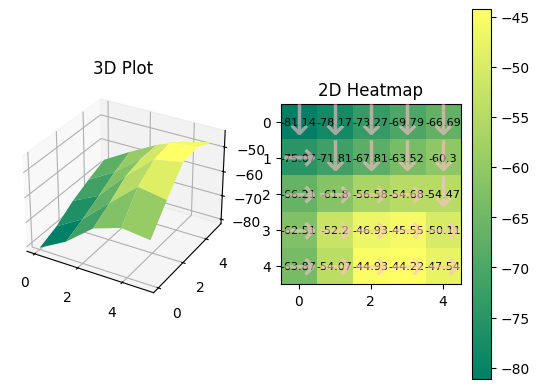

 37%|███▋      | 1847/5000 [00:04<00:07, 446.03it/s]

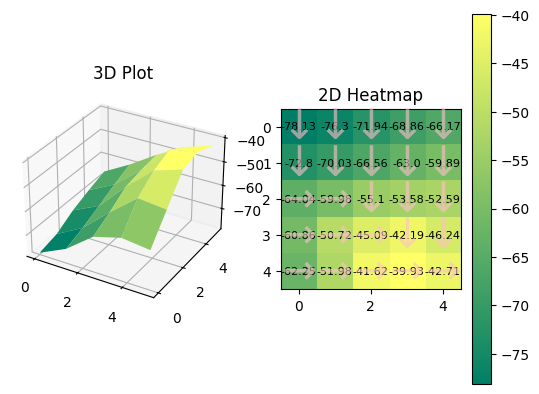

 40%|███▉      | 1995/5000 [00:04<00:06, 477.16it/s]

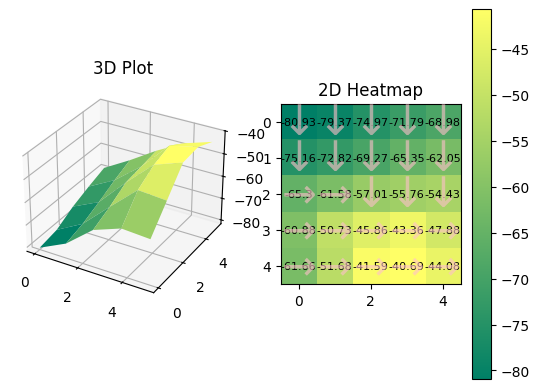

 41%|████      | 2053/5000 [00:04<00:06, 432.00it/s]

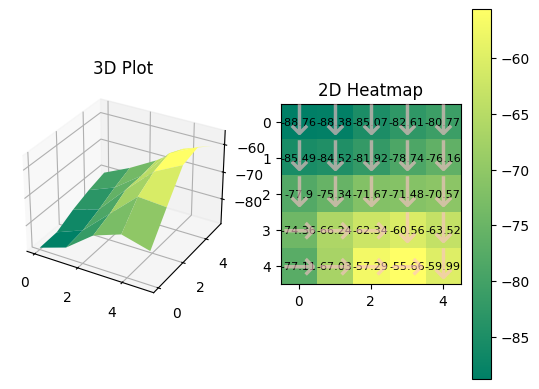

 44%|████▍     | 2196/5000 [00:04<00:05, 507.90it/s]

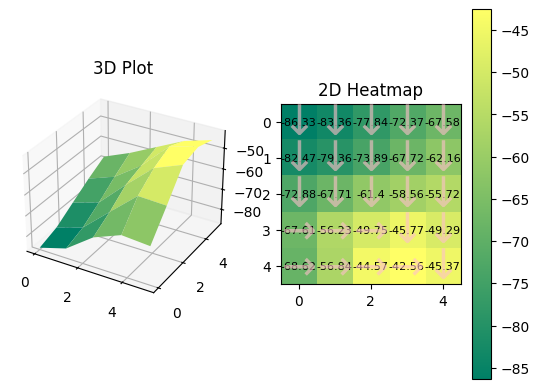

 45%|████▌     | 2255/5000 [00:05<00:06, 450.82it/s]

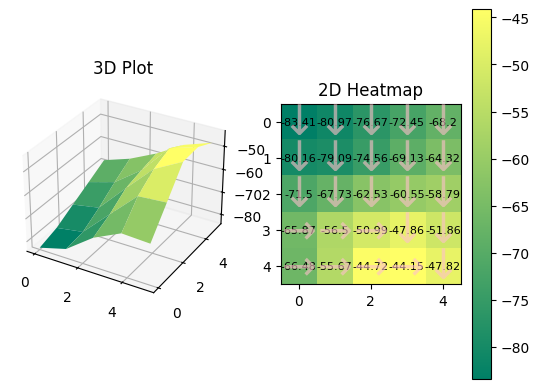

 48%|████▊     | 2394/5000 [00:05<00:05, 510.45it/s]

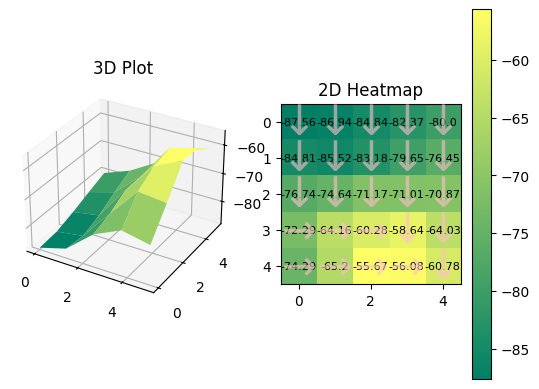

 49%|████▉     | 2452/5000 [00:05<00:05, 441.81it/s]

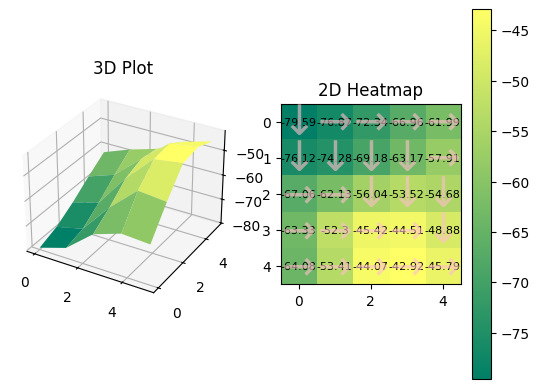

 52%|█████▏    | 2594/5000 [00:05<00:04, 513.13it/s]

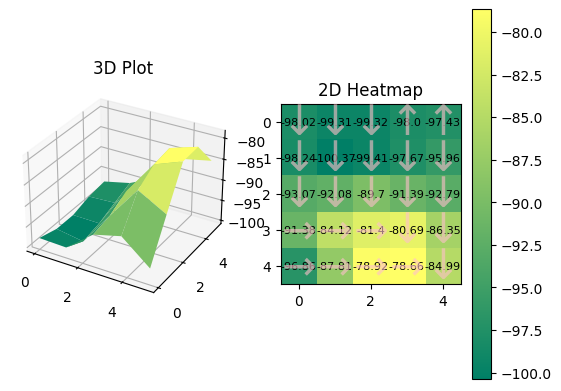

 53%|█████▎    | 2653/5000 [00:06<00:05, 394.66it/s]

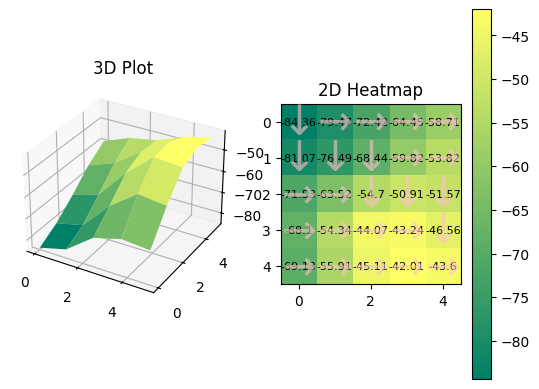

 56%|█████▌    | 2791/5000 [00:06<00:04, 478.14it/s]

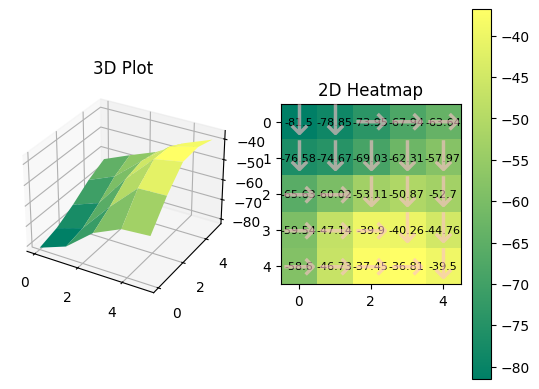

 57%|█████▋    | 2848/5000 [00:06<00:05, 427.26it/s]

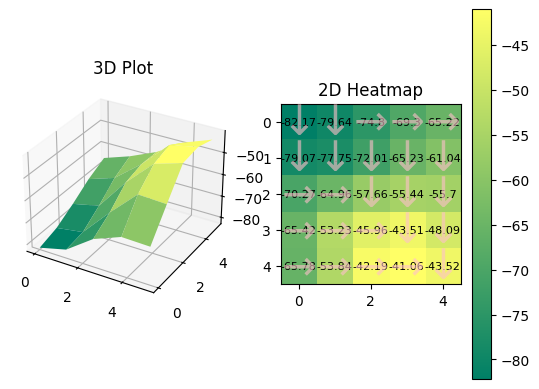

 60%|█████▉    | 2995/5000 [00:06<00:03, 504.04it/s]

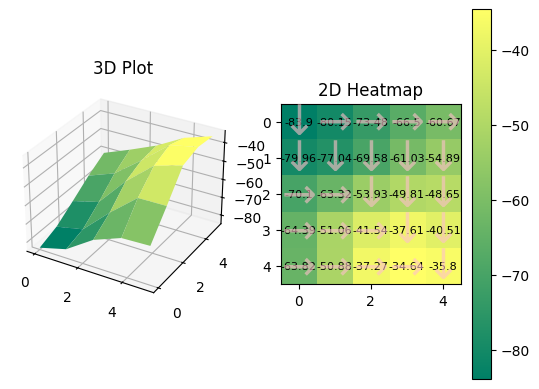

 61%|██████    | 3054/5000 [00:06<00:04, 446.93it/s]

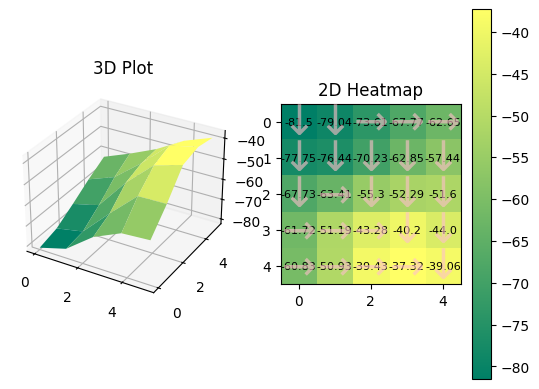

 64%|██████▍   | 3198/5000 [00:07<00:03, 515.10it/s]

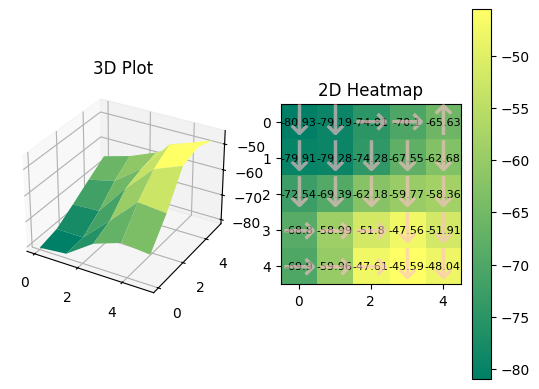

 65%|██████▌   | 3258/5000 [00:07<00:03, 456.77it/s]

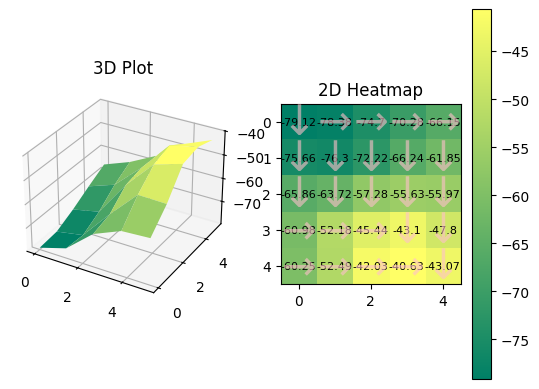

 66%|██████▌   | 3310/5000 [00:07<00:04, 362.42it/s]

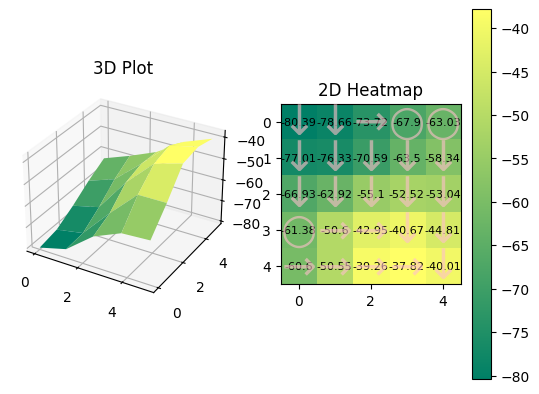

 70%|██████▉   | 3491/5000 [00:07<00:03, 482.08it/s]

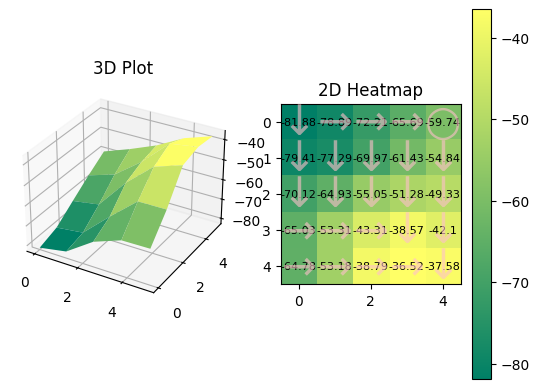

 71%|███████   | 3548/5000 [00:08<00:03, 438.84it/s]

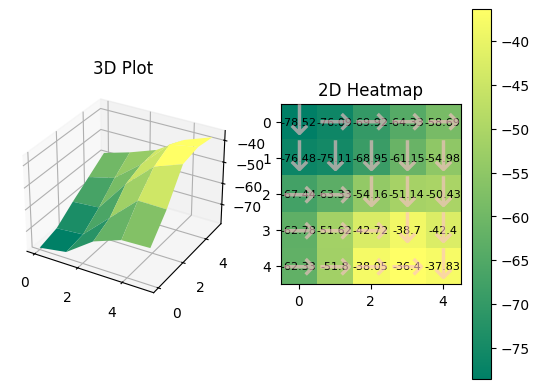

 74%|███████▍  | 3690/5000 [00:08<00:02, 505.00it/s]

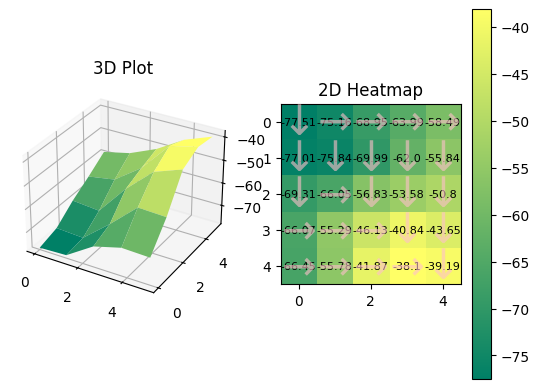

 75%|███████▍  | 3748/5000 [00:08<00:02, 449.30it/s]

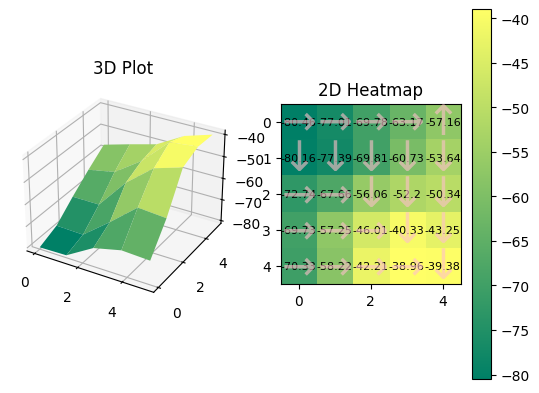

 78%|███████▊  | 3890/5000 [00:08<00:02, 510.33it/s]

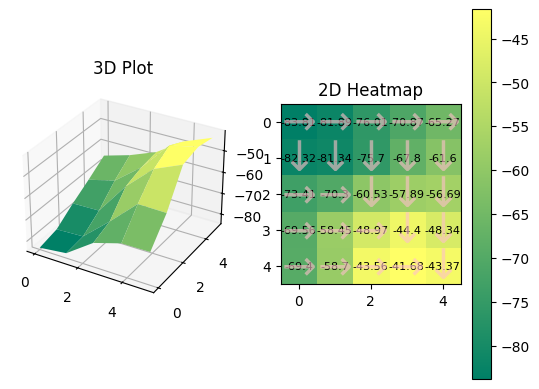

 79%|███████▉  | 3949/5000 [00:08<00:02, 449.17it/s]

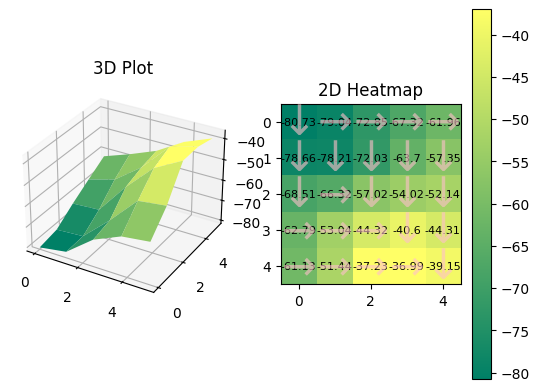

 82%|████████▏ | 4088/5000 [00:09<00:01, 458.71it/s]

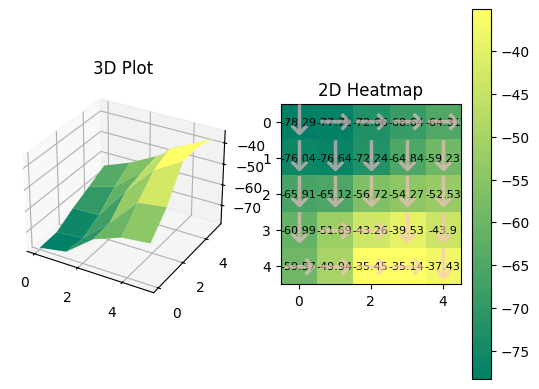

 83%|████████▎ | 4144/5000 [00:09<00:02, 412.87it/s]

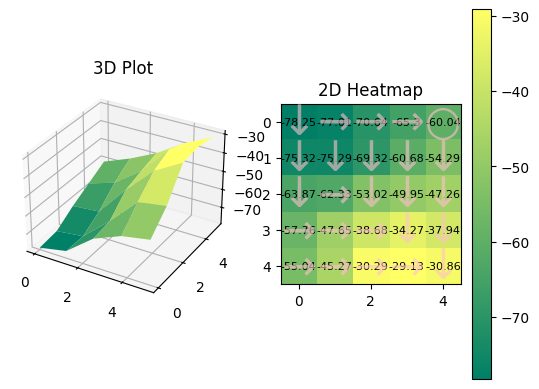

 86%|████████▌ | 4295/5000 [00:09<00:01, 506.28it/s]

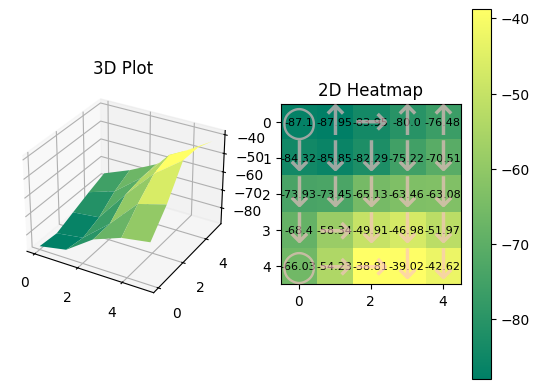

 87%|████████▋ | 4354/5000 [00:09<00:01, 453.09it/s]

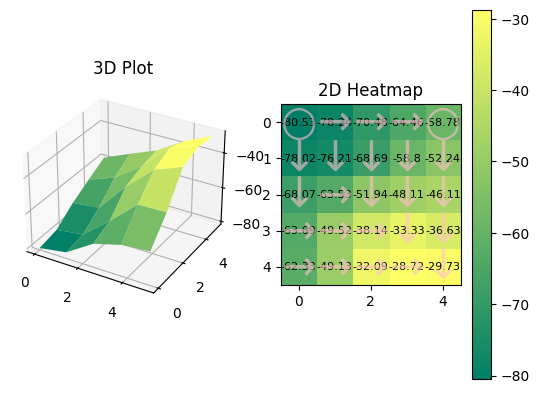

 90%|████████▉ | 4499/5000 [00:10<00:00, 525.80it/s]

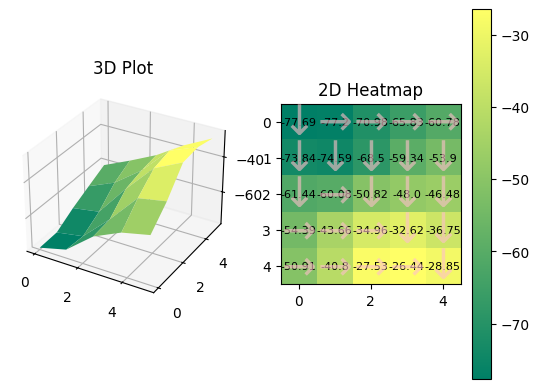

 91%|█████████ | 4559/5000 [00:10<00:00, 464.74it/s]

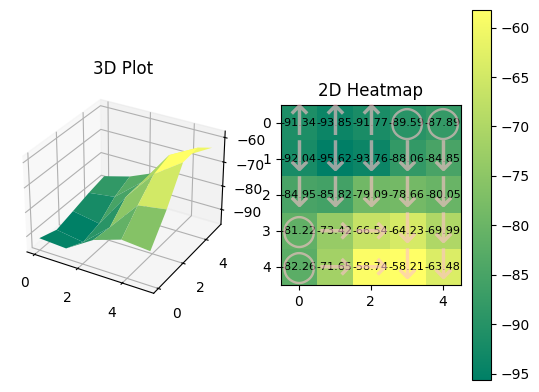

 92%|█████████▏| 4612/5000 [00:10<00:00, 420.59it/s]

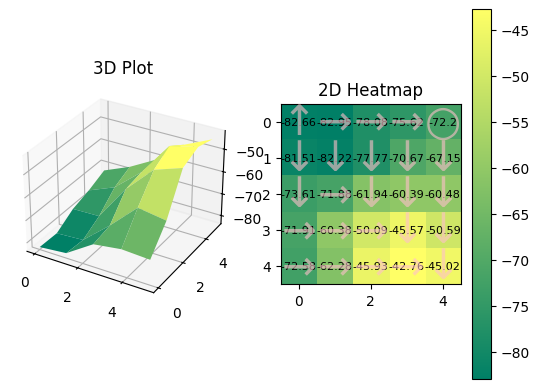

 96%|█████████▌| 4794/5000 [00:10<00:00, 527.90it/s]

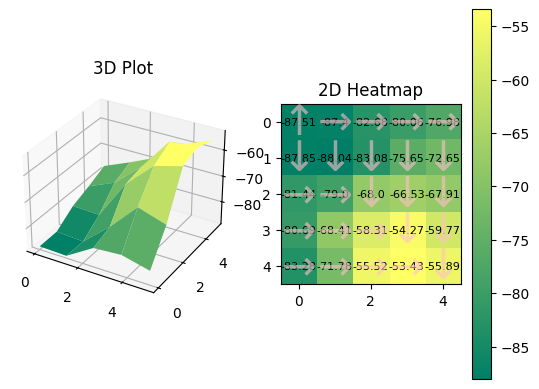

 97%|█████████▋| 4854/5000 [00:11<00:00, 402.94it/s]

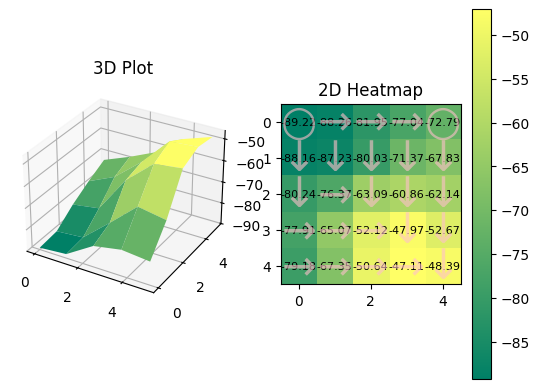

100%|██████████| 5000/5000 [00:11<00:00, 440.76it/s]


In [16]:
# 循环 5000 次，使用 tqdm 库显示进度条
for _ in tqdm.tqdm(range(5000)):
    
    # 清空优化器中的梯度信息，防止梯度累积
    optimizer.zero_grad()
    
    # 从经验池 experiencePool 中随机采样一个批次的数据
    batch = experiencePool.sample_batch(batch_size=batch_size)
    # 解包采样得到的数据，分别为当前状态、当前动作、当前得分、下一个状态、下一个动作和是否终止标志
    tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

    # 将当前状态数据重塑为 (batch_size, 1) 的形状
    tmpstate = tmpstate.reshape(batch_size,1)
    # 将当前状态转换为行列表示，方便后续处理
    tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  
    # 将下一个状态数据重塑为 (batch_size, 1) 的形状
    nextState = nextState.reshape(batch_size,1)
    # 将下一个状态转换为行列表示，方便后续处理
    nextState = np.hstack((nextState // 5, nextState % 5))  

    # 将当前状态转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 2)
    tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
    # 将下一个状态转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 2)
    nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

    # 注释掉的代码，原本用于将当前动作和下一个动作转换为 PyTorch 张量
    # tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
    # nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

    # 将当前得分转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 1)
    tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
    # 将是否终止标志转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 1)
    terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

    # 上下文管理器，不计算梯度，提高计算效率
    with torch.no_grad():
        # 输入下一个状态到神经网络，计算下一个状态的所有动作值
        next_action_values = network(nextState)  #网络
        
        # 从下一个状态的所有动作值中，选取下一个实际执行动作对应的动作值
        b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
        # 将选取的动作值转换为 PyTorch 张量，并调整形状为 (batch_size, 1)
        next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)
        
        # 注释掉的代码，原本用于选取下一个状态的所有动作值中的最大值，适用于 DQN
        # c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
        # next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)
        
        # 根据贝尔曼方程计算目标值
        target = tmpscore + (1.0 - terminal) * gamma * next_action_value

    # 输入当前状态到神经网络，计算当前状态的所有动作值
    now_action_values = network(tmpstate)    #网络
    
    # 选取当前状态下第一个样本的实际执行动作对应的动作值
    now_action_value = now_action_values[0,tmpaction[0]]
    
    # 遍历剩余的样本，依次选取实际执行动作对应的动作值，并拼接在一起
    for i in range(1,batch_size):
        now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)
    
    # 调整当前动作值的形状为 (batch_size, 1)
    now_action_value = now_action_value.view(-1,1)
    
    # 计算当前动作值和目标值之间的均方误差损失
    loss = F.mse_loss(now_action_value, target)
    # 反向传播计算梯度
    loss.backward()
    # 优化器根据计算得到的梯度更新神经网络的参数
    optimizer.step()
            
    # 每 100 次迭代执行一次以下操作
    if _ % 100 == 0:
        # 生成从 0 到 24 的状态数组
        s = np.array([[i] for i in range(25)])
        # 将状态数组转换为行列表示
        s = np.hstack((s // 5, s % 5))
        # 将状态数组转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (25, 2)
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 注释掉的代码，原本用于将神经网络输出转换为状态值并转换为 numpy 数组
        # 还原成state_values
        # state_values = network(states).view(-1).detach().numpy()
        
        # 生成从 0 到 24 的状态数组
        s = np.array([[i] for i in range(25)])
        # 将状态数组转换为行列表示
        s = np.hstack((s // 5, s % 5))
        # 将状态数组转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (25, 2)
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 将神经网络输出转换为动作值并转换为 numpy 数组
        action_values = network(states).view(-1,5).detach().numpy()

        # 根据策略和动作值计算状态值
        state_values = np.sum(policy * action_values,axis=1)

        # 选取每个状态下动作值最大的动作索引
        p = np.argmax(action_values,axis=1)
        # 调用 draw 函数绘制状态值和最优动作
        draw(state_values.reshape(5,5), p)